### This notebook performs nutrient diagnostics on CMIP6 historical CESM2 simulation

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

In [2]:
case='b.e21.BHIST.f09_g17.CMIP6-historical.001'

In [3]:
path='/glade/collections/cdg/timeseries-cmip6/' + case + '/ocn/proc/tseries/month_1/'

In [4]:
variables = ['NO3', 'PO4','SiO3']
coords = {'x':'TLONG','y':'TLAT'}

In [5]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables

#### Read in the data

In [6]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading b.e21.BHIST.f09_g17.CMIP6-historical.001
NO3
PO4
SiO3
CPU times: user 1.25 s, sys: 272 ms, total: 1.52 s
Wall time: 46.9 s


#### Keep only the necessary variables

In [7]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [8]:
ds

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, time: 1980, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time         (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound   (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
 

#### Fix the time dimension by making an average of the time bounds

In [9]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

#### Get the WOA 2018 data that has been interpolated onto the POP grid

In [10]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc'

In [11]:
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [12]:
ds_woa['z_t'] = ds.z_t
tlen=len(ds.time)
tlen

1980

#### Determine timeslices for comparison and make a mean over the time period

In [13]:
year1 = 1980
year2 = 2010

start_ts = 12 * (year1 - 1850)
stop_ts = 12 * (year2 - 1850) + 12

In [14]:
ds_mean = xr.Dataset()
ds_mean['NO3'] = ds.NO3.isel(time=slice(start_ts,stop_ts)).mean(dim='time')
ds_mean['PO4'] = ds.PO4.isel(time=slice(start_ts,stop_ts)).mean(dim='time')
ds_mean['SiO3'] = ds.SiO3.isel(time=slice(start_ts,stop_ts)).mean(dim='time')

In [15]:
NO3_diff = ds_mean.NO3 - ds_woa.NO3
PO4_diff = ds_mean.PO4 - ds_woa.PO4
SiO3_diff = ds_mean.SiO3 - ds_woa.SiO3

In [16]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

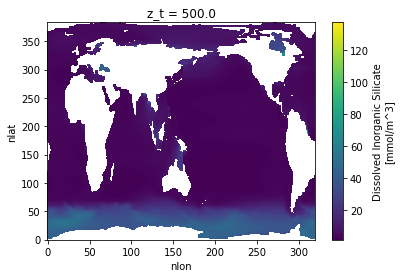

In [17]:
ds_mean.SiO3.isel(z_t=0).plot()

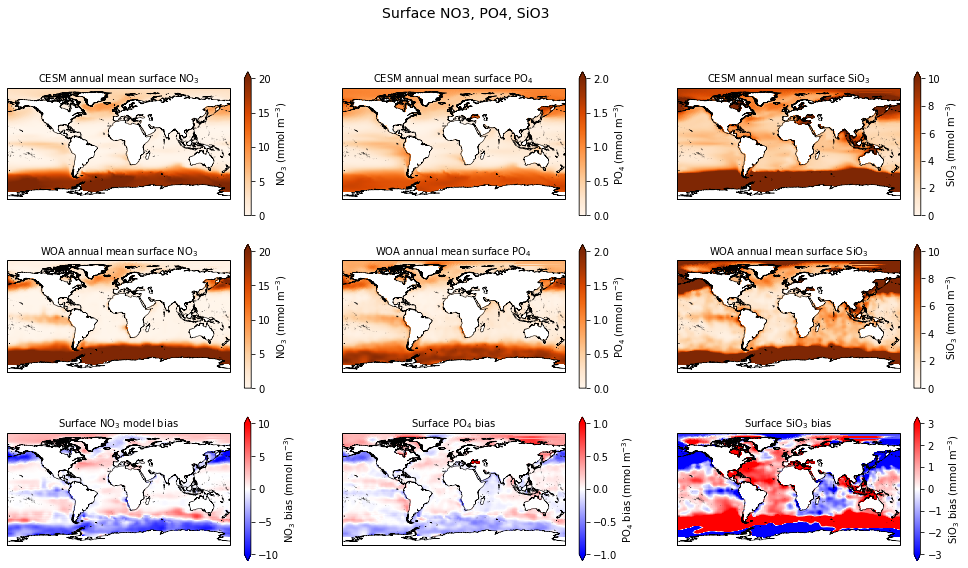

In [18]:
fig = plt.figure(figsize=(17,9))
plt.suptitle('Surface NO3, PO4, SiO3', fontsize=14)

#COLUMN 1  ---------------------------------------------------------------- NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')

#COLUMN 2 ------------------------------------------------------------------------ PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')

#COLUMN 3 ------------------------------------------------------------------------ SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean.SiO3.isel(z_t=0), vmin=0, vmax=10, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=10, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=0), 
                  vmin=-3, vmax=3, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

#### Get basin masks

In [19]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)
#region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

#### Pacific

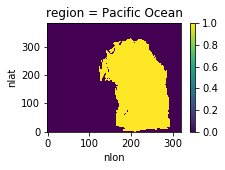

In [20]:
mask3d.isel(region=2).plot(figsize=(3,2))

In [21]:
pac_lats=ds_mean.TLAT.isel(nlon=210)
pac_lats

<xarray.DataArray 'TLAT' (nlat: 384)>
dask.array<getitem, shape=(384,), dtype=float64, chunksize=(384,), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlat) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    TLAT     (nlat) float64 dask.array<chunksize=(384,), meta=np.ndarray>
Dimensions without coordinates: nlat
Attributes:
    long_name:  array of t-grid latitudes
    units:      degrees_north

In [22]:
#make Pacific basin masked
regnum=2
woa_Pac = xr.Dataset({v: ds[v] for v in ['z_t','nlat']})
ds_Pac = xr.Dataset({v: ds[v] for v in ['z_t','nlat']})
for var in variables:
    print(var)
    woa_Pac[var] = esmlab.weighted_mean(ds_woa[var]*mask3d.isel(region=regnum), 
                                        weights=area, dim=['nlon']).compute()
    ds_Pac[var] = esmlab.weighted_mean(ds_mean[var]*mask3d.isel(region=regnum), 
                                        weights=area, dim=['nlon']).compute()

NO3
PO4
SiO3


In [23]:
Pac_diff = ds_Pac - woa_Pac

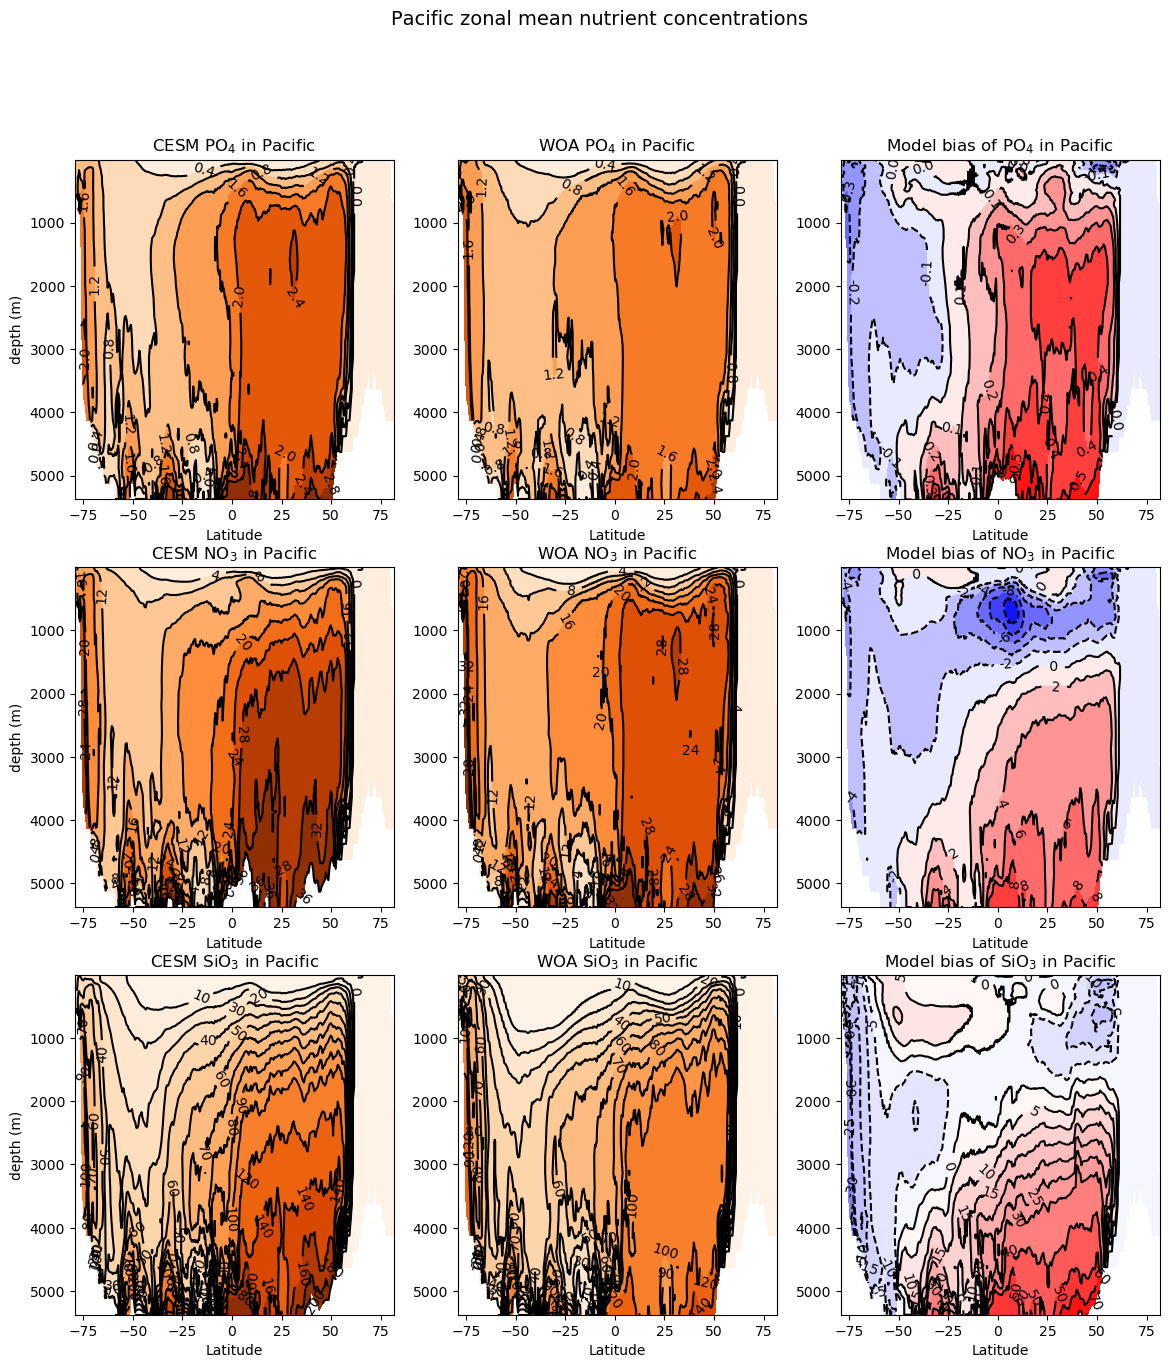

In [24]:
style.use('default')
fig = plt.figure(figsize=(14,15))

plt.suptitle('Pacific zonal mean nutrient concentrations', fontsize=14)

#ROW 1  - PO4 CESM

ax = fig.add_subplot(3,3,1)
levels = [0,0.4,0.8,1.2,1.6,2,2.4,2.8,3.2]
ax.set_title('CESM PO$_4$ in Pacific')
pc=ax.contourf(pac_lats, depths, ds_Pac['PO4'], levels, cmap='Oranges')
contour = plt.contour(pac_lats, depths, ds_Pac['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 1  - PO4 WOA

ax = fig.add_subplot(3,3,2)
ax.set_title('WOA PO$_4$ in Pacific')
pc=ax.contourf(pac_lats, depths, woa_Pac['PO4'], levels, cmap='Oranges')
contour = plt.contour(pac_lats, depths, woa_Pac['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 1  - PO4 diff

ax = fig.add_subplot(3,3,3)
levels = [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6]
ax.set_title('Model bias of PO$_4$ in Pacific')
pc=ax.contourf(pac_lats, depths, Pac_diff['PO4'], levels, cmap='bwr')
contour = plt.contour(pac_lats, depths, Pac_diff['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#----------------------------
#ROW 2  - NO3 CESM

ax = fig.add_subplot(3,3,4)
levels = [0,4,8,12,16,20,24,28,32,36]
ax.set_title('CESM NO$_3$ in Pacific')
pc=ax.contourf(pac_lats, depths, ds_Pac['NO3'], levels, cmap='Oranges')
contour = plt.contour(pac_lats, depths, ds_Pac['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 2  - NO3 WOA

ax = fig.add_subplot(3,3,5)
ax.set_title('WOA NO$_3$ in Pacific')
pc=ax.contourf(pac_lats, depths, woa_Pac['NO3'], levels, cmap='Oranges')
contour = plt.contour(pac_lats, depths, woa_Pac['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 2  - NO3 diff

ax = fig.add_subplot(3,3,6)
levels = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12]
ax.set_title('Model bias of NO$_3$ in Pacific')
pc=ax.contourf(pac_lats, depths, Pac_diff['NO3'], levels, cmap='bwr')
contour = plt.contour(pac_lats, depths, Pac_diff['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#----------------------------
#ROW 3  - SiO3 CESM

ax = fig.add_subplot(3,3,7)
levels = [0,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]
ax.set_title('CESM SiO$_3$ in Pacific')
pc=ax.contourf(pac_lats, depths, ds_Pac['SiO3'], levels, cmap='Oranges')
contour = plt.contour(pac_lats, depths, ds_Pac['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()


#ROW 3  - SiO3 WOA

ax = fig.add_subplot(3,3,8)
ax.set_title('WOA SiO$_3$ in Pacific')
pc=ax.contourf(pac_lats, depths, woa_Pac['SiO3'], levels, cmap='Oranges')
contour = plt.contour(pac_lats, depths, woa_Pac['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 3  - SiO3 diff

ax = fig.add_subplot(3,3,9)
levels = [-70,-60,-50,-40,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,40,50,60,70]
ax.set_title('Model bias of SiO$_3$ in Pacific')
pc=ax.contourf(pac_lats, depths, Pac_diff['SiO3'], levels, cmap='bwr')
contour = plt.contour(pac_lats, depths, Pac_diff['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#### Atlantic

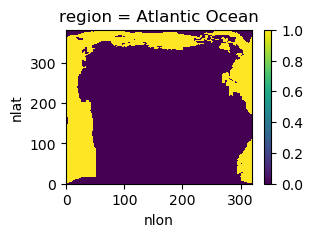

In [25]:
mask3d.isel(region=1).plot(figsize=(3,2))

In [26]:
atl_lats=ds_mean.TLAT.isel(nlon=0)
atl_lats

<xarray.DataArray 'TLAT' (nlat: 384)>
dask.array<getitem, shape=(384,), dtype=float64, chunksize=(384,), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlat) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    TLAT     (nlat) float64 dask.array<chunksize=(384,), meta=np.ndarray>
Dimensions without coordinates: nlat
Attributes:
    long_name:  array of t-grid latitudes
    units:      degrees_north

In [27]:
#make Atlantic basin masked
regnum=1
woa_Atl = xr.Dataset({v: ds[v] for v in ['z_t','nlat']})
ds_Atl = xr.Dataset({v: ds[v] for v in ['z_t','nlat']})
for var in variables:
    print(var)
    woa_Atl[var] = esmlab.weighted_mean(ds_woa[var]*mask3d.isel(region=regnum), 
                                        weights=area, dim=['nlon']).compute()
    ds_Atl[var] = esmlab.weighted_mean(ds_mean[var]*mask3d.isel(region=regnum), 
                                        weights=area, dim=['nlon']).compute()

NO3
PO4
SiO3


In [28]:
Atl_diff = ds_Atl - woa_Atl

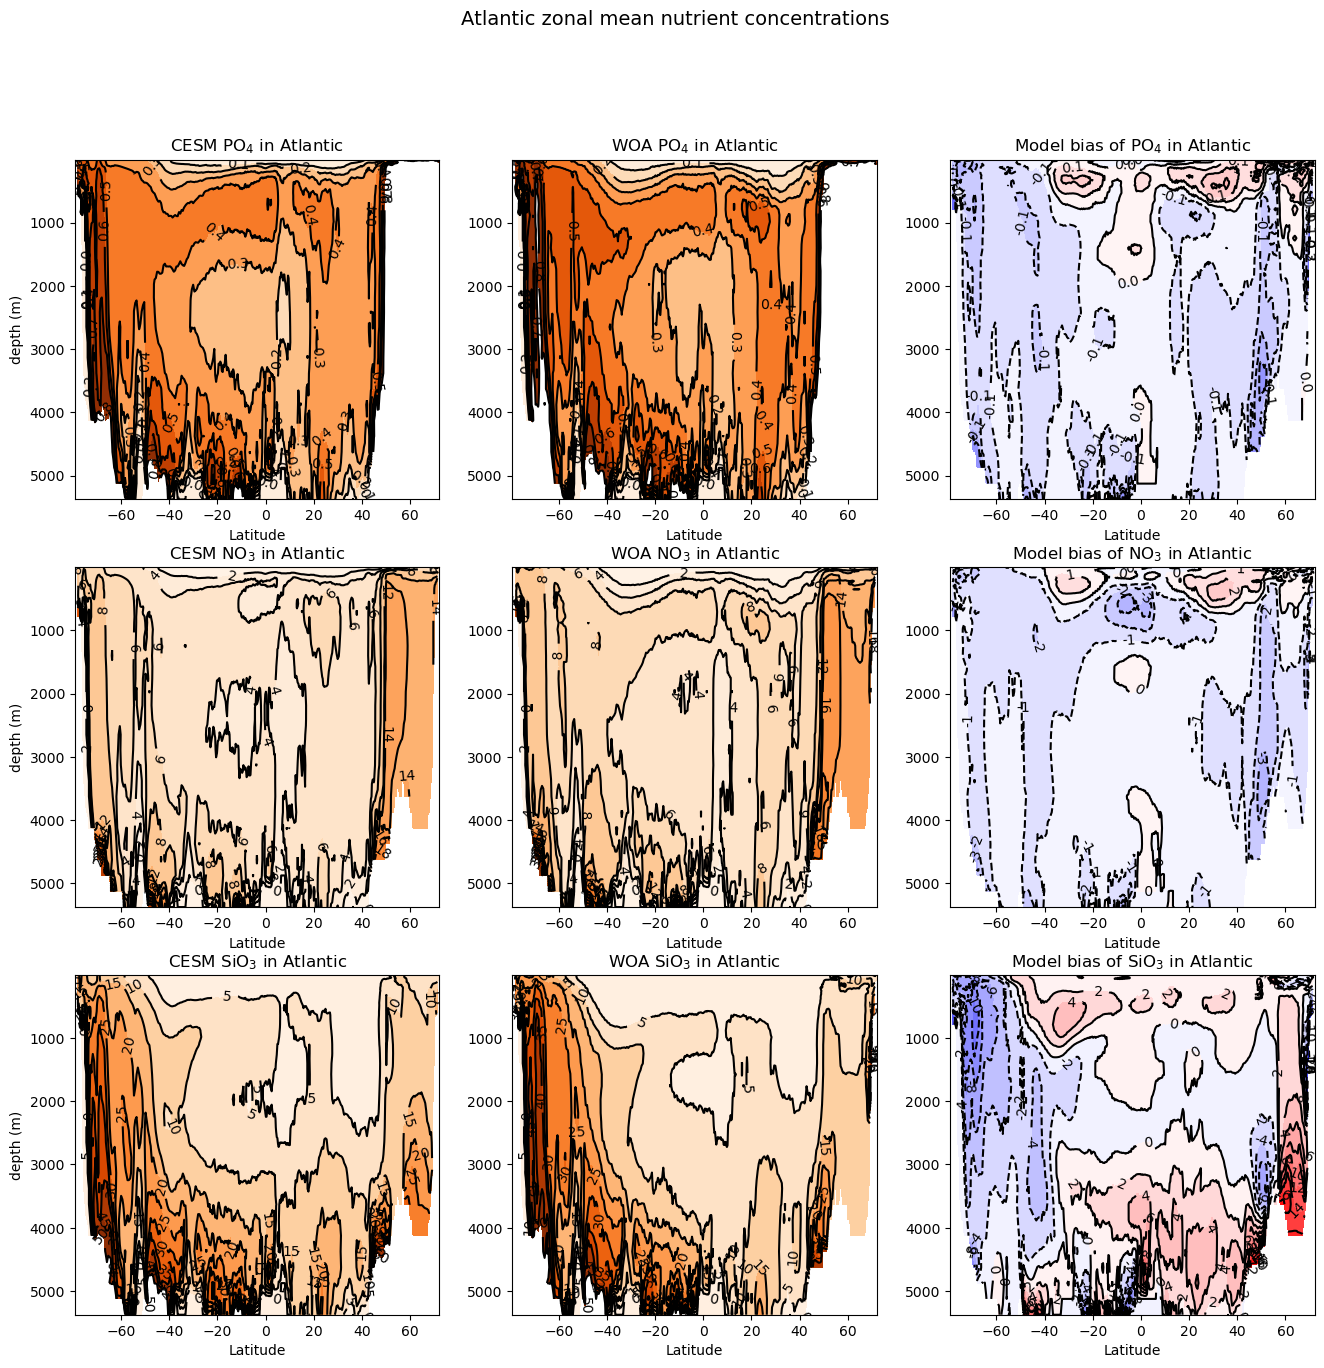

In [39]:
style.use('default')
fig = plt.figure(figsize=(16,15))

plt.suptitle('Atlantic zonal mean nutrient concentrations', fontsize=14)

#ROW 1  - PO4 CESM

ax = fig.add_subplot(3,3,1)
levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
ax.set_title('CESM PO$_4$ in Atlantic')
pc=ax.contourf(atl_lats, depths, ds_Atl['PO4'], levels, cmap='Oranges')
contour = plt.contour(atl_lats, depths, ds_Atl['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 1  - PO4 WOA

ax = fig.add_subplot(3,3,2)
ax.set_title('WOA PO$_4$ in Atlantic')
pc=ax.contourf(atl_lats, depths, woa_Atl['PO4'], levels, cmap='Oranges')
contour = plt.contour(atl_lats, depths, woa_Atl['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 1  - PO4 diff

ax = fig.add_subplot(3,3,3)
levels = [-0.6,-0.5,-0.4,-0.3,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6]
ax.set_title('Model bias of PO$_4$ in Atlantic')
pc=ax.contourf(atl_lats, depths, Atl_diff['PO4'], levels, cmap='bwr')
contour = plt.contour(atl_lats, depths, Atl_diff['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#----------------------------
#ROW 2  - NO3 CESM

ax = fig.add_subplot(3,3,4)
levels = [0,2,4,6,8,12,14,16,18,20,22,24,26,28,30,32,34,36]
ax.set_title('CESM NO$_3$ in Atlantic')
pc=ax.contourf(atl_lats, depths, ds_Atl['NO3'], levels, cmap='Oranges')
contour = plt.contour(atl_lats, depths, ds_Atl['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 2  - NO3 WOA

ax = fig.add_subplot(3,3,5)
ax.set_title('WOA NO$_3$ in Atlantic')
pc=ax.contourf(atl_lats, depths, woa_Atl['NO3'], levels, cmap='Oranges')
contour = plt.contour(atl_lats, depths, woa_Atl['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 2  - NO3 diff

ax = fig.add_subplot(3,3,6)
levels = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12]
ax.set_title('Model bias of NO$_3$ in Atlantic')
pc=ax.contourf(atl_lats, depths, Atl_diff['NO3'], levels, cmap='bwr')
contour = plt.contour(atl_lats, depths, Atl_diff['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#----------------------------
#ROW 3  - SiO3 CESM

ax = fig.add_subplot(3,3,7)
levels = [0,5,10,15,20,25,30,35,40,45,50]
ax.set_title('CESM SiO$_3$ in Atlantic')
pc=ax.contourf(atl_lats, depths, ds_Atl['SiO3'], levels, cmap='Oranges')
contour = plt.contour(atl_lats, depths, ds_Atl['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()


#ROW 3  - SiO3 WOA

ax = fig.add_subplot(3,3,8)
ax.set_title('WOA SiO$_3$ in Atlantic')
pc=ax.contourf(atl_lats, depths, woa_Atl['SiO3'], levels, cmap='Oranges')
contour = plt.contour(atl_lats, depths, woa_Atl['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 3  - SiO3 diff

ax = fig.add_subplot(3,3,9)
levels = [-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20]
ax.set_title('Model bias of SiO$_3$ in Atlantic')
pc=ax.contourf(atl_lats, depths, Atl_diff['SiO3'], levels, cmap='bwr')
contour = plt.contour(atl_lats, depths, Atl_diff['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#### Indian

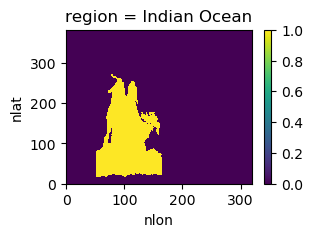

In [30]:
mask3d.isel(region=3).plot(figsize=(3,2))

In [31]:
ind_lats=ds_mean.TLAT.isel(nlon=100)
ind_lats

<xarray.DataArray 'TLAT' (nlat: 384)>
dask.array<getitem, shape=(384,), dtype=float64, chunksize=(384,), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlat) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    TLAT     (nlat) float64 dask.array<chunksize=(384,), meta=np.ndarray>
Dimensions without coordinates: nlat
Attributes:
    long_name:  array of t-grid latitudes
    units:      degrees_north

In [32]:
#make Indian basin masked
regnum=3
woa_Ind = xr.Dataset({v: ds[v] for v in ['z_t','nlat']})
ds_Ind = xr.Dataset({v: ds[v] for v in ['z_t','nlat']})
for var in variables:
    print(var)
    woa_Ind[var] = esmlab.weighted_mean(ds_woa[var]*mask3d.isel(region=regnum), 
                                        weights=area, dim=['nlon']).compute()
    ds_Ind[var] = esmlab.weighted_mean(ds_mean[var]*mask3d.isel(region=regnum), 
                                        weights=area, dim=['nlon']).compute()

NO3
PO4
SiO3


In [33]:
Ind_diff = ds_Ind - woa_Ind

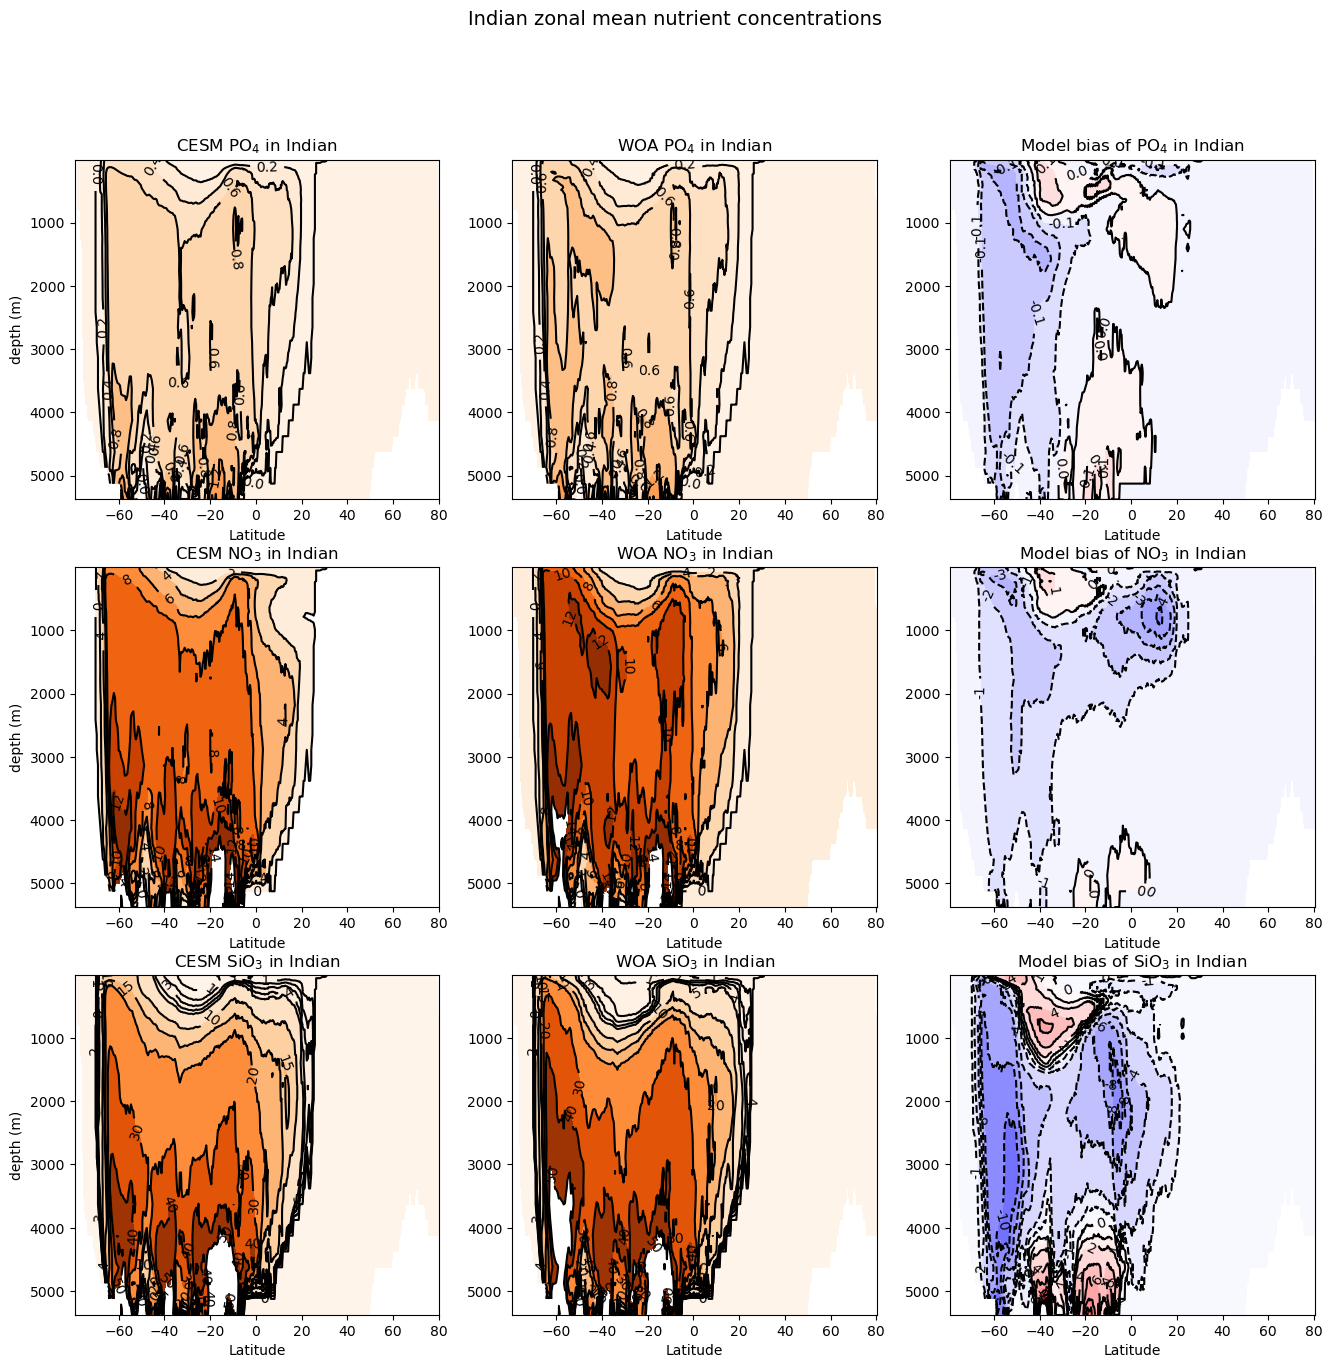

In [47]:
style.use('default')
fig = plt.figure(figsize=(16,15))

plt.suptitle('Indian zonal mean nutrient concentrations', fontsize=14)

#ROW 1  - PO4 CESM

ax = fig.add_subplot(3,3,1)
#levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
levels = [0,0.2,0.4,0.6,0.8,1.2,1.6,2,2.4,2.8,3.2]
ax.set_title('CESM PO$_4$ in Indian')
pc=ax.contourf(ind_lats, depths, ds_Ind['PO4'], levels, cmap='Oranges')
contour = plt.contour(ind_lats, depths, ds_Ind['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 1  - PO4 WOA

ax = fig.add_subplot(3,3,2)
ax.set_title('WOA PO$_4$ in Indian')
pc=ax.contourf(ind_lats, depths, woa_Ind['PO4'], levels, cmap='Oranges')
contour = plt.contour(ind_lats, depths, woa_Ind['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 1  - PO4 diff

ax = fig.add_subplot(3,3,3)
levels = [-0.6,-0.5,-0.4,-0.3,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6]
ax.set_title('Model bias of PO$_4$ in Indian')
pc=ax.contourf(ind_lats, depths, Ind_diff['PO4'], levels, cmap='bwr')
contour = plt.contour(ind_lats, depths, Ind_diff['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#----------------------------
#ROW 2  - NO3 CESM

ax = fig.add_subplot(3,3,4)
levels = [0,2,4,6,8,10,12,14]
ax.set_title('CESM NO$_3$ in Indian')
pc=ax.contourf(ind_lats, depths, ds_Ind['NO3'], levels, cmap='Oranges')
contour = plt.contour(ind_lats, depths, ds_Ind['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 2  - NO3 WOA

ax = fig.add_subplot(3,3,5)
ax.set_title('WOA NO$_3$ in Indian')
pc=ax.contourf(ind_lats, depths, woa_Ind['NO3'], levels, cmap='Oranges')
contour = plt.contour(ind_lats, depths, woa_Ind['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 2  - NO3 diff

ax = fig.add_subplot(3,3,6)
levels = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12]
ax.set_title('Model bias of NO$_3$ in Indian')
pc=ax.contourf(ind_lats, depths, Ind_diff['NO3'], levels, cmap='bwr')
contour = plt.contour(ind_lats, depths, Ind_diff['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#----------------------------
#ROW 3  - SiO3 CESM

ax = fig.add_subplot(3,3,7)
levels = [0,1,2,3,4,5,10,15,20,30,40,50]
ax.set_title('CESM SiO$_3$ in Indian')
pc=ax.contourf(ind_lats, depths, ds_Ind['SiO3'], levels, cmap='Oranges')
contour = plt.contour(ind_lats, depths, ds_Ind['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 3  - SiO3 WOA

ax = fig.add_subplot(3,3,8)
ax.set_title('WOA SiO$_3$ in Indian')
pc=ax.contourf(ind_lats, depths, woa_Ind['SiO3'], levels, cmap='Oranges')
contour = plt.contour(ind_lats, depths, woa_Ind['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

#ROW 3  - SiO3 diff

ax = fig.add_subplot(3,3,9)
levels = [-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,-1,0,1,2,4,6,8,10,12,14,16,18,20]
ax.set_title('Model bias of SiO$_3$ in Indian')
pc=ax.contourf(ind_lats, depths, Ind_diff['SiO3'], levels, cmap='bwr')
contour = plt.contour(ind_lats, depths, Ind_diff['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()

### Vertical profiles

In [35]:
ds_glb = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_glb['NO3']= esmlab.weighted_mean(ds_mean['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(ds_mean['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(ds_mean['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [36]:
ds_glb_woa = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

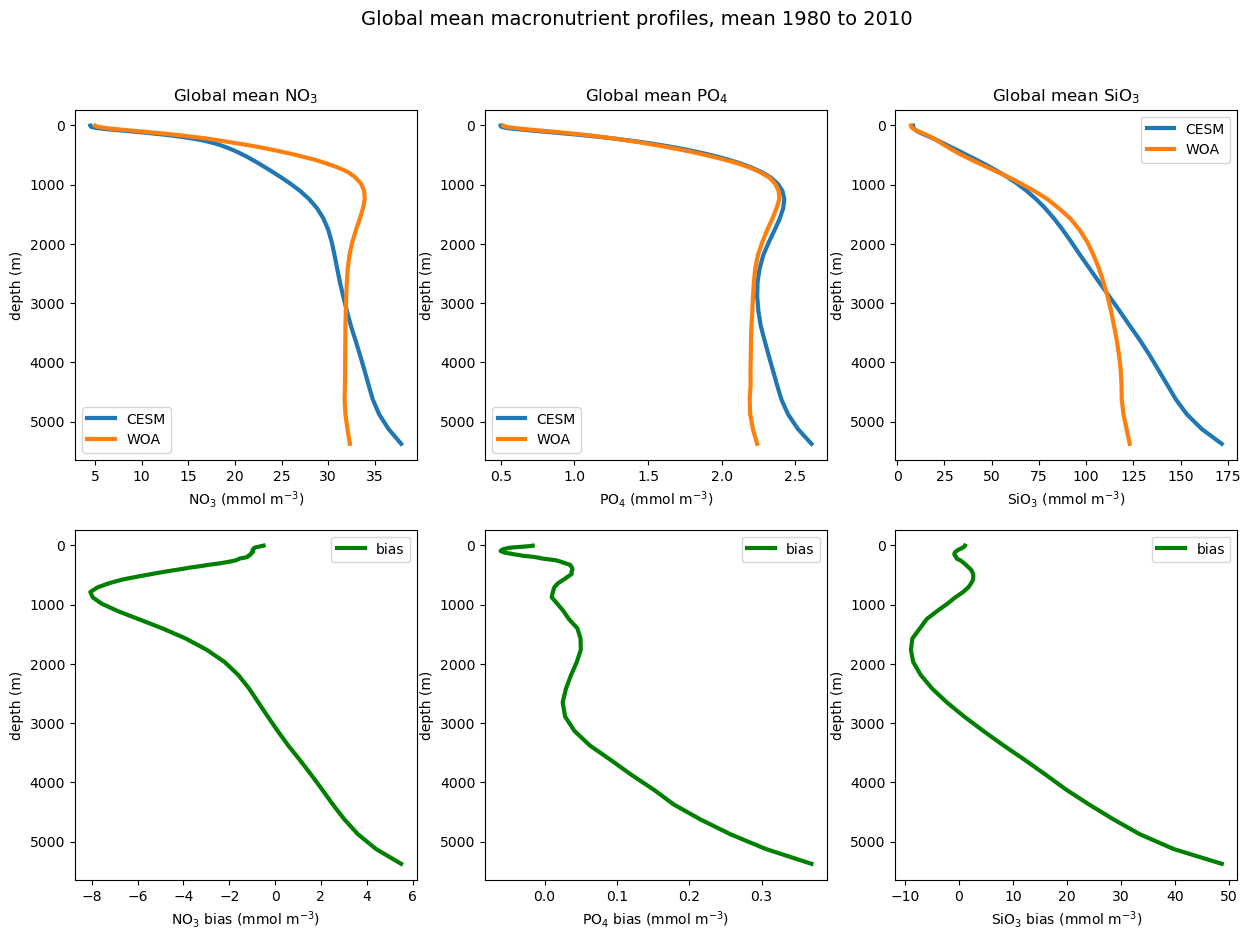

In [37]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles, mean 1980 to 2010', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

